In [18]:
import json
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import accuracy_score

In [19]:
with open('linkedin-cvs-annotated.json', 'r', encoding='utf-8-sig') as f:
    data = json.load(f) 

In [20]:
def build_profile_text(person_jobs, only_active=True, max_jobs=5):
    
    jobs = person_jobs
    if only_active:
        active = [j for j in person_jobs if j.get("status") == "ACTIVE"]
        jobs = active if active else person_jobs

    jobs = sorted(jobs, key=lambda j: j.get("startDate") or "", reverse=True)


    parts = []
    for j in jobs[:max_jobs]:
        pos = (j.get("position") or "").strip()
        org = (j.get("organization") or "").strip()

        if pos and org:
            parts.append(f"{pos} at {org}")
        elif pos:
            parts.append(pos)

    return " | ".join(parts)


In [21]:
rows = []
for i, person_jobs in enumerate(data):
    rows.append({
        "person_id": i,
        "profile_text": build_profile_text(person_jobs, only_active=True, max_jobs=5)
    })

df = pd.DataFrame(rows)


In [22]:
def extract_labels(data):
    dept_set, sen_set = set(), set()

    for person_jobs in data:
        for j in person_jobs:
            d = j.get("department")
            s = j.get("seniority")

            if d and str(d).strip():
                dept_set.add(str(d).strip())

            if s and str(s).strip():
                sen_set.add(str(s).strip())

    return sorted(dept_set), sorted(sen_set)

department_labels, seniority_labels = extract_labels(data)
print("Department labels:", department_labels)
print("Seniority labels:", seniority_labels)


Department labels: ['Administrative', 'Business Development', 'Consulting', 'Customer Support', 'Human Resources', 'Information Technology', 'Marketing', 'Other', 'Project Management', 'Purchasing', 'Sales']
Seniority labels: ['Director', 'Junior', 'Lead', 'Management', 'Professional', 'Senior']


In [23]:
dept_prompts = [f"This job belongs to the {l} department." for l in department_labels]
sen_prompts  = [f"This job has {l} seniority level." for l in seniority_labels]


In [24]:
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

# label embeddings
dept_emb = model.encode(dept_prompts, normalize_embeddings=True)
sen_emb  = model.encode(sen_prompts,  normalize_embeddings=True)

# profile embeddings
texts = df["profile_text"].fillna("").tolist()
text_emb = model.encode(texts, normalize_embeddings=True)

# cosine similarity
dept_sim = cosine_similarity(text_emb, dept_emb)
sen_sim  = cosine_similarity(text_emb, sen_emb)

# best label
dept_idx = dept_sim.argmax(axis=1)
sen_idx  = sen_sim.argmax(axis=1)

df["predicted_department"] = [department_labels[i] for i in dept_idx]
df["predicted_seniority"]  = [seniority_labels[i] for i in sen_idx]

# confidence scores
df["dept_score"] = dept_sim.max(axis=1)
df["sen_score"]  = sen_sim.max(axis=1)


In [25]:
def get_ground_truth(person_jobs):
    active = [j for j in person_jobs if j.get("status") == "ACTIVE"]
    if not active:
        return None, None

    active = sorted(active, key=lambda j: j.get("startDate") or "", reverse=True)
    j = active[0]
    return j.get("department"), j.get("seniority")


In [26]:
true_dept, true_sen = [], []

for person_jobs in data:
    d, s = get_ground_truth(person_jobs)
    true_dept.append(d)
    true_sen.append(s)

df["true_department"] = true_dept
df["true_seniority"]  = true_sen


In [27]:
eval_df = df.dropna(subset=["true_department", "true_seniority"])

dept_acc = accuracy_score(eval_df["true_department"], eval_df["predicted_department"])
sen_acc  = accuracy_score(eval_df["true_seniority"],  eval_df["predicted_seniority"])

print(f"Department accuracy: {dept_acc:.3f}")
print(f"Seniority accuracy:  {sen_acc:.3f}")


Department accuracy: 0.207
Seniority accuracy:  0.301


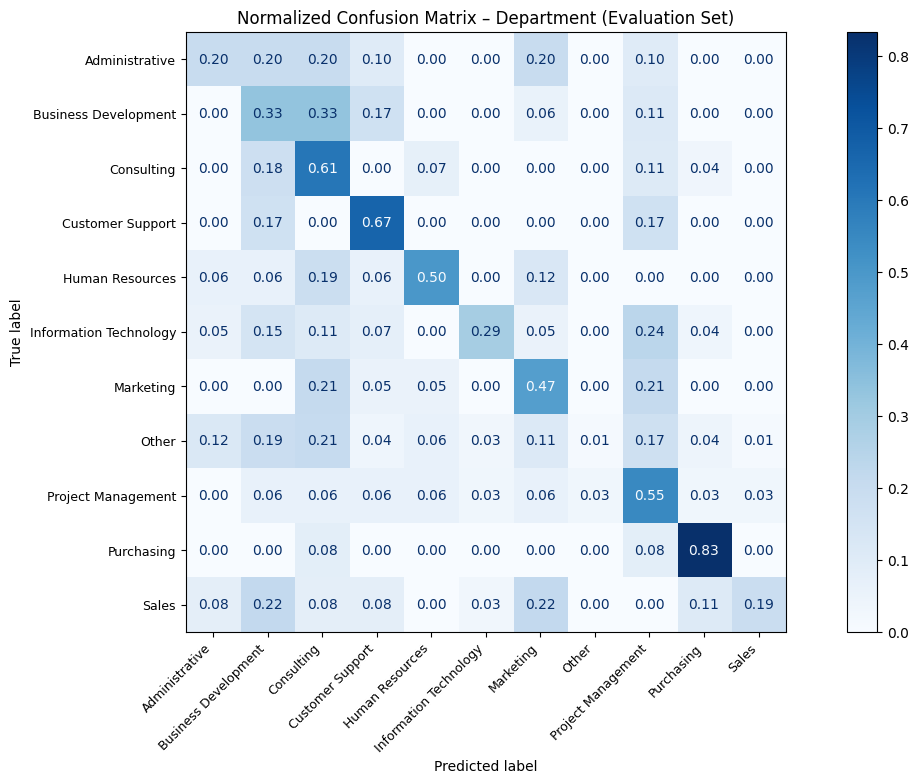

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

labels = [
    "Administrative",
    "Business Development",
    "Consulting",
    "Customer Support",
    "Human Resources",
    "Information Technology",
    "Marketing",
    "Other",
    "Project Management",
    "Purchasing",
    "Sales"
]

cm_dept_norm = confusion_matrix(
    eval_df["true_department"],
    eval_df["predicted_department"],
    labels=labels,
    normalize="true" 
)

fig, ax = plt.subplots(figsize=(18, 10))

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_dept_norm,
    display_labels=labels
)

disp.plot(
    ax=ax,
    cmap="Blues",
    values_format=".2f", 
    xticks_rotation=45
)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=9)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=9)

ax.set_title("Normalized Confusion Matrix – Department (Evaluation Set)")

fig.subplots_adjust(bottom=0.28, left=0.22)

plt.show()


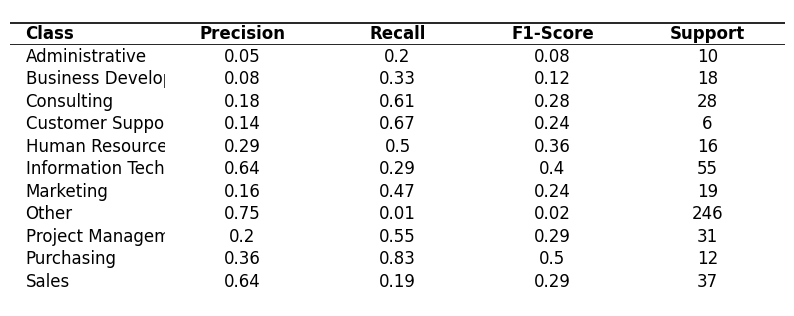

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

labels = [
    "Administrative",
    "Business Development",
    "Consulting",
    "Customer Support",
    "Human Resources",
    "Information Technology",
    "Marketing",
    "Other",
    "Project Management",
    "Purchasing",
    "Sales"
]

report = classification_report(
    eval_df["true_department"],
    eval_df["predicted_department"],
    labels=labels,
    output_dict=True,
    zero_division=0
)

df = pd.DataFrame(report).transpose()
df = df.loc[labels, ["precision", "recall", "f1-score", "support"]]
df = df.round(2)
df["support"] = df["support"].astype(int)

df.insert(0, "Class", df.index)
df.columns = ["Class", "Precision", "Recall", "F1-Score", "Support"]

fig_h = 0.55 + 0.30 * len(df)
fig, ax = plt.subplots(figsize=(10, fig_h))
ax.axis("off")

table = ax.table(
    cellText=df.values,
    colLabels=df.columns,
    cellLoc="center",
    colLoc="center",
    loc="center"
)

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 1.35)

for (r, c), cell in table.get_celld().items():
    cell.set_linewidth(0)
    if r == 0:
        cell.set_text_props(weight="bold")
    if c == 0:
        cell.get_text().set_ha("left")

for c in range(len(df.columns)):
    hc = table[(0, c)]
    hc.set_linewidth(1.2)
    hc.visible_edges = "TB"

plt.savefig("embedding_department_classification_report.png", dpi=300, bbox_inches="tight")
plt.show()


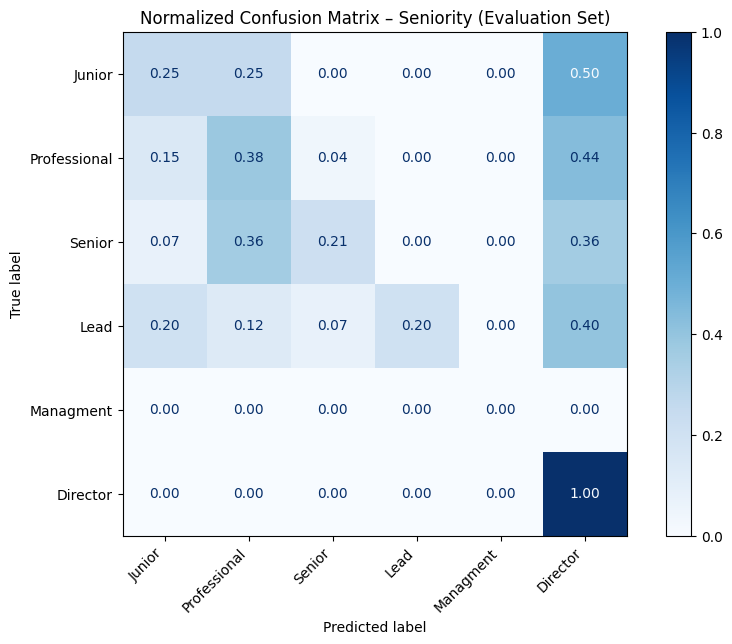

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

seniority_labels = [
    "Junior",
    "Professional",
    "Senior",
    "Lead",
    "Managment", 
    "Director"
]

cm_sen_norm = confusion_matrix(
    eval_df["true_seniority"],
    eval_df["predicted_seniority"],
    labels=seniority_labels,
    normalize="true" 
)

fig, ax = plt.subplots(figsize=(12, 8))

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm_sen_norm,
    display_labels=seniority_labels
)

disp.plot(
    ax=ax,
    cmap="Blues",
    values_format=".2f", 
    xticks_rotation=45
)

ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha="right", fontsize=10)
ax.set_yticklabels(ax.get_yticklabels(), fontsize=10)

ax.set_title("Normalized Confusion Matrix – Seniority (Evaluation Set)")

fig.subplots_adjust(bottom=0.25, left=0.25)

plt.show()




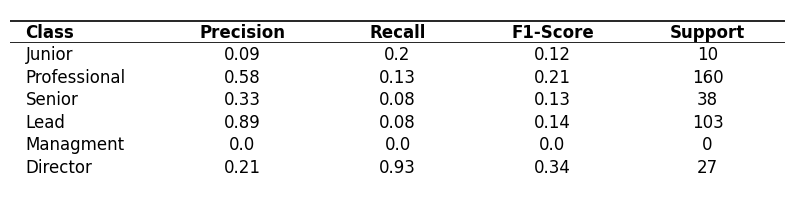

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

seniority_labels = [
    "Junior",
    "Professional",
    "Senior",
    "Lead",
    "Managment",
    "Director"
]

report = classification_report(
    eval_df["true_seniority"],
    eval_df["predicted_seniority"],
    labels=seniority_labels,
    output_dict=True,
    zero_division=0
)

df = pd.DataFrame(report).transpose()
df = df.loc[seniority_labels, ["precision", "recall", "f1-score", "support"]]
df = df.round(2)
df["support"] = df["support"].astype(int)

df.insert(0, "Class", df.index)
df.columns = ["Class", "Precision", "Recall", "F1-Score", "Support"]

fig_h = 0.55 + 0.30 * len(df)
fig, ax = plt.subplots(figsize=(10, fig_h))
ax.axis("off")

table = ax.table(
    cellText=df.values,
    colLabels=df.columns,
    cellLoc="center",
    colLoc="center",
    loc="center"
)

table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1, 1.35)

for (r, c), cell in table.get_celld().items():
    cell.set_linewidth(0)
    if r == 0:
        cell.set_text_props(weight="bold")
    if c == 0:
        cell.get_text().set_ha("left")

for c in range(len(df.columns)):
    hc = table[(0, c)]
    hc.set_linewidth(1.2)
    hc.visible_edges = "TB"

plt.savefig("embedding_seniority_classification_report.png", dpi=300, bbox_inches="tight")
plt.show()


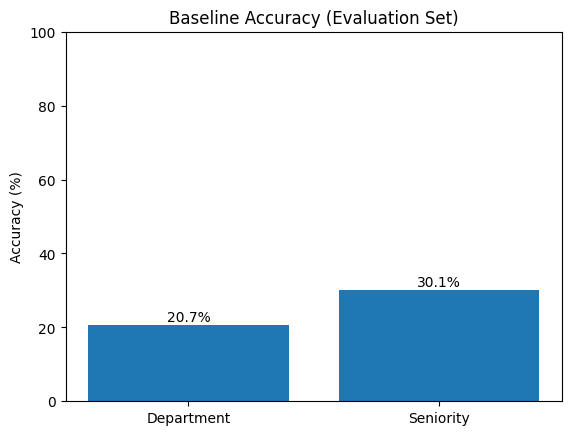

In [ ]:
import matplotlib.pyplot as plt

# accuracy
dept_acc = 0.207
sen_acc = 0.301

labels = ["Department", "Seniority"]
values = [dept_acc * 100, sen_acc * 100]

plt.figure()
plt.bar(labels, values)
plt.ylim(0, 100)
plt.ylabel("Accuracy (%)")
plt.title("Baseline Accuracy (Evaluation Set)")

# show values on bar
for i, v in enumerate(values):
    plt.text(i, v + 1, f"{v:.1f}%", ha="center")

plt.show()
